<h1 style ="color:brown;">Dogs vs Cats</h1>

<strong>In this project, a model will be made to identify and distinguish pictures of cats and dogs by using a pretrained model and a small dataset</strong>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras=tf.keras

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

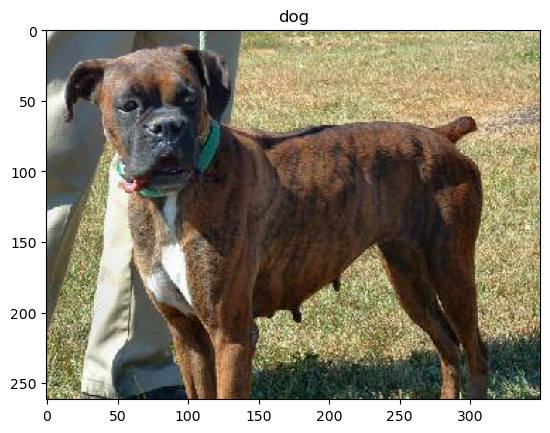

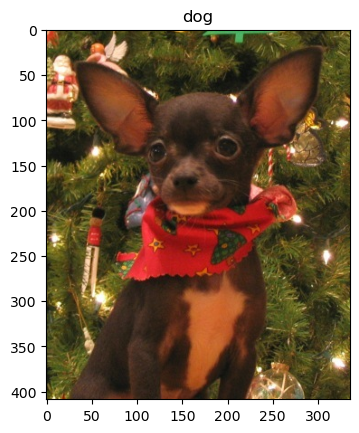

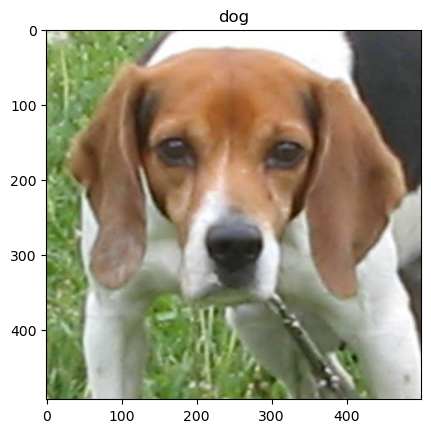

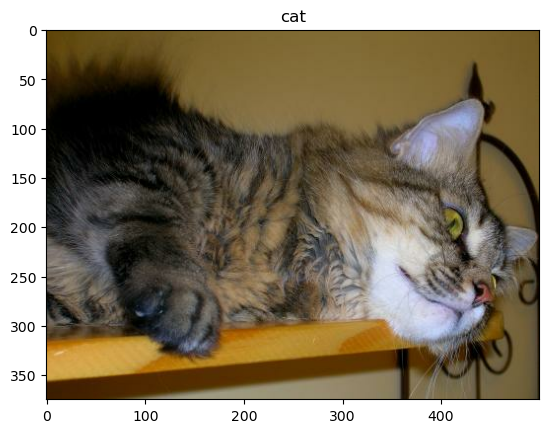

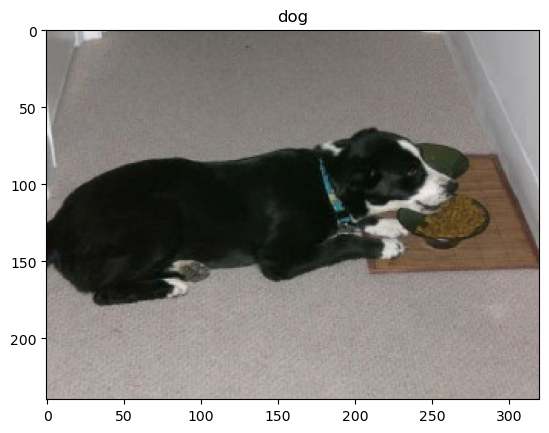

In [5]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

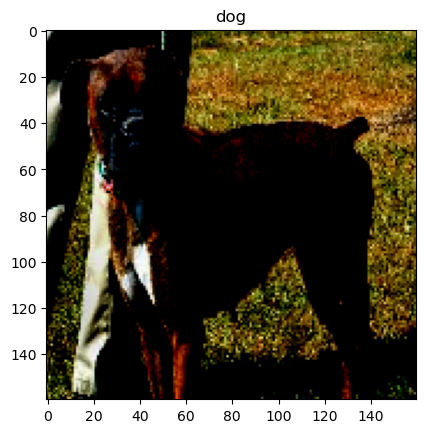

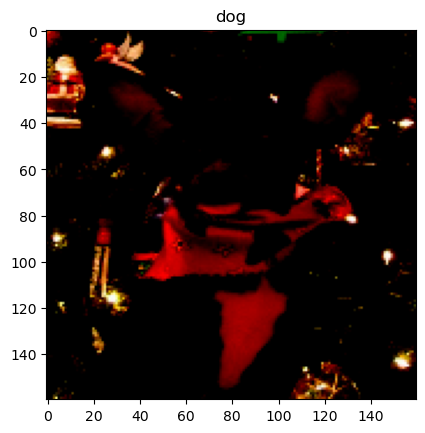

In [10]:
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
for img, label in raw_train.take(2):
  print("Original shape:", img.shape)

for img, label in train.take(2):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


# Assigning Convolutional Base from pre-trained model

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [15]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Freezing Layers (since our model is pre-trained, re-training it is not necessary for the Convolutional Base)

In [16]:
base_model.trainable = False

In [19]:
#Classifier
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [20]:
#Prediction Layer (Only one dense neuron needed due to only having two classes)
prediction_layer = keras.layers.Dense(1)

In [21]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Small Learning rate to ensure no major changes are made to our model

In [24]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 3/20 [===>..........................] - ETA: 14s - loss: 0.6946 - accuracy: 0.6146

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


15/20 [=====================>........] - ETA: 3s - loss: 0.7540 - accuracy: 0.5146

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 18s 730ms/step - loss: 0.7732 - accuracy: 0.5047


In [26]:
#training with our images 
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
165/582 [=======>......................] - ETA: 4:38 - loss: 0.4204 - accuracy: 0.7937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 4:17 - loss: 0.3885 - accuracy: 0.8147

208/582 [=========>....................] - ETA: 4:10 - loss: 0.3782 - accuracy: 0.8212

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 3:29 - loss: 0.3283 - accuracy: 0.8498

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 1:04 - loss: 0.2418 - accuracy: 0.8949

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 55s - loss: 0.2380 - accuracy: 0.8969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 48s - loss: 0.2352 - accuracy: 0.8982

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 30s - loss: 0.2278 - accuracy: 0.9017

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 25s - loss: 0.2260 - accuracy: 0.9025

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9066

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 501s 849ms/step - loss: 0.2175 - accuracy: 0.9066 - val_loss: 0.0892 - val_accuracy: 0.9665
Epoch 2/3
165/582 [=======>......................] - ETA: 7:31 - loss: 0.0808 - accuracy: 0.9723

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 6:55 - loss: 0.0826 - accuracy: 0.9711

208/582 [=========>....................] - ETA: 6:38 - loss: 0.0818 - accuracy: 0.9704

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 5:05 - loss: 0.0827 - accuracy: 0.9693

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 1:21 - loss: 0.0784 - accuracy: 0.9704

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 1:10 - loss: 0.0786 - accuracy: 0.9703

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 1:01 - loss: 0.0779 - accuracy: 0.9705

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 48s - loss: 0.0769 - accuracy: 0.9711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 41s - loss: 0.0766 - accuracy: 0.9712

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9717

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 816s 1s/step - loss: 0.0756 - accuracy: 0.9717 - val_loss: 0.0643 - val_accuracy: 0.9759
Epoch 3/3
165/582 [=======>......................] - ETA: 9:25 - loss: 0.0622 - accuracy: 0.9775

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 8:25 - loss: 0.0616 - accuracy: 0.9773

208/582 [=========>....................] - ETA: 8:06 - loss: 0.0607 - accuracy: 0.9773

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 6:28 - loss: 0.0626 - accuracy: 0.9762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 1:55 - loss: 0.0620 - accuracy: 0.9766

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 1:39 - loss: 0.0618 - accuracy: 0.9767

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 1:27 - loss: 0.0622 - accuracy: 0.9766

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 53s - loss: 0.0613 - accuracy: 0.9769

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 45s - loss: 0.0612 - accuracy: 0.9770

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9774

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 792s 1s/step - loss: 0.0602 - accuracy: 0.9774 - val_loss: 0.0550 - val_accuracy: 0.9794
[0.9065555930137634, 0.9716818928718567, 0.9773777723312378]
